# Credit Card Approval Prediction


## Context

Credit score cards are a common risk control method in the financial industry. It uses personal information and data submitted by credit card applicants to predict the probability of future defaults and credit card borrowings. The bank is able to decide whether to issue a credit card to the applicant. Credit scores can objectively quantify the magnitude of risk.

Generally speaking, credit score cards are based on historical data. Once encountering large economic fluctuations. Past models may lose their original predictive power. Logistic model is a common method for credit scoring. Because Logistic is suitable for binary classification tasks and can calculate the coefficients of each feature. In order to facilitate understanding and operation, the score card will multiply the logistic regression coefficient by a certain value (such as 100) and round it.

At present, with the development of machine learning algorithms. More predictive methods such as Boosting, Random Forest, and Support Vector Machines have been introduced into credit card scoring. However, these methods often do not have good transparency. It may be difficult to provide customers and regulators with a reason for rejection or acceptance.

## Task

Build a machine learning model to predict if an applicant is 'good' or 'bad' client, different from other tasks, the definition of 'good' or 'bad' is not given. You should use some techique, such as vintage analysis to construct you label. Also, unbalance data problem is a big problem in this task.

In [1420]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [1421]:
# There are 2 datasets 

# 1. application records (contains all information about the applicants)

application_records = pd.read_csv('../../data/raw/application_record.csv')

# 2. credit records (contains information about the loan and depth)

credit_records = pd.read_csv('../../data/raw/credit_record.csv')

# 1. Exploratory Data Analysis

In [1422]:
display(application_records.head())
display(credit_records.head())

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [1423]:
# Standardizing the column names for both files: 

def columns(x):
    return x.lower()

application_records.columns = list(map(columns, application_records.columns))
credit_records.columns = list(map(columns, credit_records.columns))


In [1424]:
# Checking if the data of the two files match in length: 

print('Application Records = {}'.format(application_records.shape))
print('Credit Records = {}'.format(credit_records.shape))

#There is a big difference in data length in the two files

Application Records = (438557, 18)
Credit Records = (1048575, 3)


## Predicted Feature

**Column Status:** 

- 0: 1-29 days past due
- 1: 30-59 days past due
- 2: 60-89 days overdue
- 3: 90-119 days overdue
- 4: 120-149 days overdue
- 5: Overdue or bad debts, write-offs for more than 150 days
- C: paid off that month
- X: No loan for the month



**Column Months_Balance:**

The month of the extracted data is the starting point, backwards

- 0: current month
- -1: previous month
- ...


In [1425]:
print(credit_records.shape)
credit_records['id'].nunique()

(1048575, 3)


45985

In [1426]:
credit_records['status'].value_counts()

C    442031
0    383120
X    209230
1     11090
5      1693
2       868
3       320
4       223
Name: status, dtype: int64

In [1427]:
pivot_tb = pd.pivot_table(credit_records, index = ['id', 'status'], aggfunc = 'count').reset_index()
pivot_tb


,id,status,months_balance
0,5001711,0,3
1,5001711,X,1
2,5001712,0,10
3,5001712,C,9
4,5001713,X,22
...,...,...,...
94138,5150483,X,18
94139,5150484,0,12
94140,5150484,C,1
94141,5150485,0,2


### Labeling the customers

In [1428]:
# Find percentage of customers for each status

ratio_overdue = []

# ratio of customers overdue more than 1 day:
overdue0 = round(len(pivot_tb[pivot_tb['status'] == '0']) / pivot_tb['id'].nunique(), 3)
ratio_overdue.append(overdue0)

# ratio of customers overdue more than 30 days:
overdue1 = round(len(pivot_tb[pivot_tb['status'] == '1']) / pivot_tb['id'].nunique(), 3)
ratio_overdue.append(overdue1)

# ratio of customers overdue more than 60 day:
overdue2 = round(len(pivot_tb[pivot_tb['status'] == '2']) / pivot_tb['id'].nunique(), 4)
ratio_overdue.append(overdue2)

# ratio of customers overdue more than 90 day:
overdue3 = round(len(pivot_tb[pivot_tb['status'] == '3']) / pivot_tb['id'].nunique(), 4)
ratio_overdue.append(overdue3)
                     
# ratio of customers overdue more than 120 day:
overdue4 = round(len(pivot_tb[pivot_tb['status'] == '4']) / pivot_tb['id'].nunique(), 5)
ratio_overdue.append(overdue4)

# ratio of customers overdue more than 150 day:
overdue5 = round(len(pivot_tb[pivot_tb['status'] == '5']) / pivot_tb['id'].nunique(), 5)
ratio_overdue.append(overdue5)

ratio_overdue

[0.869, 0.113, 0.013, 0.0058, 0.00413, 0.00424]

In [1429]:
# Creating a Dictonary and a Dataframe out of the caculated ratio.

dict = {'default': ['>1', '>30', '>60', '>90', '>120', '>150'], 
       'ratio': ratio_overdue}

pd.DataFrame.from_dict(dict)


,default,ratio
0,>1,0.86900
1,>30,0.11300
2,>60,0.01300
3,>90,0.00580
4,>120,0.00413
5,>150,0.00424


The percentage of customers who are overdue more than 1 day lies by 87%. If we would consider customers with STATUS 0 as RISK Customers this would lead to a lot of people being classified as bad. Those would not receive a loan. However the bank would also loose a lot of profit by being too risk averse. 

Considering the customers with more than 30 day overdue also leads to a relative high amount of customers classified as bad. More than 10% of customers are overdue more than 30days at least once. 

Customers overdue more than 60 days are already at a reasonable percentag of 1.3% 

**---> Customers >= STATUS 2 will be labeled as RISK!** 


In [1430]:
# Flag Customers as 1 or 0. 1 = RISK / 0 = NO RISK

pivot_tb['default_flag'] = [0 if i in ['X', '0', '1', 'C'] else 1 for i in pivot_tb['status']] #each Status per customer will be flagged
pivot_tb.head()

# this approach leads to several values per customer -> however I am only interested in weather the customer is classified as riks or no risk. 

,id,status,months_balance,default_flag
0,5001711,0,3,0
1,5001711,X,1,0
2,5001712,0,10,0
3,5001712,C,9,0
4,5001713,X,22,0


In [1431]:
# A customer which has one or more month with a status higher than 2 will be classified as RISK

# 1. Compute the sum of all status labels per customer
flagged = pd.pivot_table(pivot_tb, index = 'id', values = 'default_flag', aggfunc = 'sum').reset_index()

# 2. if a customer has on ore more values flagged as 1, the overall lable will be RISK
pivot_tb['default_flag'] = pivot_tb['default_flag'].apply(lambda x: 1 if x >= 1 else 0) #save in a new column

/Users/steib/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='default_flag', ylabel='count'>

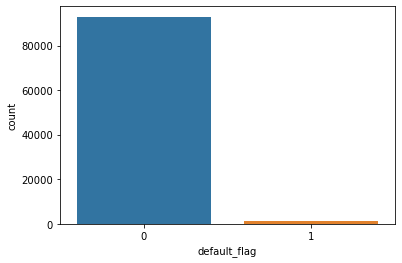

In [1432]:
# Checking for plausability of calculation:

pivot_tb['default_flag'].value_counts()

sns.countplot(pivot_tb['default_flag'])

# -- > There is a CLASS IMBALANCE

In [1433]:

var_dep = pivot_tb.copy()
duplicated_id = var_dep[var_dep.duplicated(['id'])]
duplicated_indexes = list(duplicated_id.index.values)

In [1434]:
var_dep.drop(var_dep.index[duplicated_indexes], inplace = True)

## Independent Features

In [1435]:
application_records.head()

,id,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,name_income_type,name_education_type,name_family_status,name_housing_type,days_birth,days_employed,flag_mobil,flag_work_phone,flag_phone,flag_email,occupation_type,cnt_fam_members
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [1436]:
# Are the columns in the correct dtype

application_records.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   438557 non-null  int64  
 1   code_gender          438557 non-null  object 
 2   flag_own_car         438557 non-null  object 
 3   flag_own_realty      438557 non-null  object 
 4   cnt_children         438557 non-null  int64  
 5   amt_income_total     438557 non-null  float64
 6   name_income_type     438557 non-null  object 
 7   name_education_type  438557 non-null  object 
 8   name_family_status   438557 non-null  object 
 9   name_housing_type    438557 non-null  object 
 10  days_birth           438557 non-null  int64  
 11  days_employed        438557 non-null  int64  
 12  flag_mobil           438557 non-null  int64  
 13  flag_work_phone      438557 non-null  int64  
 14  flag_phone           438557 non-null  int64  
 15  flag_email       

#### Missing Values 

In [1437]:
application_records.isna().sum()

id                          0
code_gender                 0
flag_own_car                0
flag_own_realty             0
cnt_children                0
amt_income_total            0
name_income_type            0
name_education_type         0
name_family_status          0
name_housing_type           0
days_birth                  0
days_employed               0
flag_mobil                  0
flag_work_phone             0
flag_phone                  0
flag_email                  0
occupation_type        134203
cnt_fam_members             0
dtype: int64

In [1438]:
application_records['occupation_type'].value_counts( dropna = False)

NaN                      134203
Laborers                  78240
Core staff                43007
Sales staff               41098
Managers                  35487
Drivers                   26090
High skill tech staff     17289
Accountants               15985
Medicine staff            13520
Cooking staff              8076
Security staff             7993
Cleaning staff             5845
Private service staff      3456
Low-skill Laborers         2140
Secretaries                2044
Waiters/barmen staff       1665
Realty agents              1041
HR staff                    774
IT staff                    604
Name: occupation_type, dtype: int64

In [1439]:
# Fill Missing Values: 

application_records['occupation_type'] = application_records['occupation_type'].fillna('Others')
application_records['occupation_type'].value_counts( dropna = False)

Others                   134203
Laborers                  78240
Core staff                43007
Sales staff               41098
Managers                  35487
Drivers                   26090
High skill tech staff     17289
Accountants               15985
Medicine staff            13520
Cooking staff              8076
Security staff             7993
Cleaning staff             5845
Private service staff      3456
Low-skill Laborers         2140
Secretaries                2044
Waiters/barmen staff       1665
Realty agents              1041
HR staff                    774
IT staff                    604
Name: occupation_type, dtype: int64

### Categorical Values

In [1440]:
application_cat = application_records.select_dtypes('object')
application_cat['id'] = application_records.loc[:, 'id']

/var/folders/dj/n16zrnc50j79vq_pt7btwyg40000gn/T/ipykernel_44533/1525766102.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  application_cat['id'] = application_records.loc[:, 'id']


In [1441]:
print(application_cat.shape)
application_num = application_records.select_dtypes(np.number)
print(application_num.shape)

(438557, 9)
(438557, 10)


#### Reducing & Mergin Classes

In [1442]:
# checking for the amount of classes in each feature
application_cat.nunique()

code_gender                 2
flag_own_car                2
flag_own_realty             2
name_income_type            5
name_education_type         5
name_family_status          5
name_housing_type           6
occupation_type            19
id                     438510
dtype: int64

In [1443]:
# checking the frequency of classes in INCOME TYPE
application_cat['name_income_type'].value_counts()

Working                 226104
Commercial associate    100757
Pensioner                75493
State servant            36186
Student                     17
Name: name_income_type, dtype: int64

In [1444]:
# I will merge 'Student' and 'Pensioner' 

application_cat.loc[(application_cat['name_income_type'] == 'Student') | (application_cat['name_income_type'] == 'Pensioner'), 'name_income_type'] = 'Others'
application_cat['name_income_type'].value_counts()


/Users/steib/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Working                 226104
Commercial associate    100757
Others                   75510
State servant            36186
Name: name_income_type, dtype: int64

In [1445]:
# checking the frequency of classes in INCOME TYPE
application_cat['name_education_type'].value_counts()

Secondary / secondary special    301821
Higher education                 117522
Incomplete higher                 14851
Lower secondary                    4051
Academic degree                     312
Name: name_education_type, dtype: int64

In [1446]:
# I will merge all classes containing 'SECONDARY' and 'HIGHER' 

application_cat.loc[(application_cat['name_education_type'] == 'Lower secondary') | (application_cat['name_education_type'] == 'Secondary / secondary special'), 'name_education_type'] = 'Secondary education'
application_cat.loc[(application_cat['name_education_type'] == 'Academic degree'), 'name_education_type'] = 'Higher education'
application_cat['name_education_type'].value_counts()

Secondary education    305872
Higher education       117834
Incomplete higher       14851
Name: name_education_type, dtype: int64

In [1447]:
# checking frequency of classes in FAMILY STATUS
application_cat['name_family_status'].value_counts()

Married                 299828
Single / not married     55271
Civil marriage           36532
Separated                27251
Widow                    19675
Name: name_family_status, dtype: int64

In [1448]:
# I will group to 2 classes 'Married' and 'Not Married'
application_cat.loc[(application_cat['name_family_status'] == 'Civil marriage'), 'name_family_status'] = 'Married'
application_cat.loc[(application_cat['name_family_status'] != 'Married'), 'name_family_status'] = 'Not Married'
application_cat['name_family_status'].value_counts()

Married        336360
Not Married    102197
Name: name_family_status, dtype: int64

In [1449]:
# checking frequency of classes in HOUSING TYPE
application_cat['name_housing_type'].value_counts()

House / apartment      393831
With parents            19077
Municipal apartment     14214
Rented apartment         5974
Office apartment         3922
Co-op apartment          1539
Name: name_housing_type, dtype: int64

In [1450]:
application_cat.loc[(application_cat['name_housing_type'] == 'Municipal apartment') | (application_cat['name_housing_type'] == 'Office apartment') |
                    (application_cat['name_housing_type'] == 'Office apartment') | 
                    (application_cat['name_housing_type'] == 'Co-op apartment'), 'name_housing_type'] = 'Rented apartment'

application_cat['name_housing_type'].value_counts()

House / apartment    393831
Rented apartment      25649
With parents          19077
Name: name_housing_type, dtype: int64

In [1451]:
# checking frequency of classes in OCCUPATION
application_cat['occupation_type'].value_counts()

Others                   134203
Laborers                  78240
Core staff                43007
Sales staff               41098
Managers                  35487
Drivers                   26090
High skill tech staff     17289
Accountants               15985
Medicine staff            13520
Cooking staff              8076
Security staff             7993
Cleaning staff             5845
Private service staff      3456
Low-skill Laborers         2140
Secretaries                2044
Waiters/barmen staff       1665
Realty agents              1041
HR staff                    774
IT staff                    604
Name: occupation_type, dtype: int64

In [1452]:
# Grouping into 3 classes: Others, Laborers, Core Staff


application_cat.loc[(application_cat['occupation_type'] == 'Drivers') | (application_cat['occupation_type'] == 'Cooking staff') | 
                    (application_cat['occupation_type'] == 'Security staff') | (application_cat['occupation_type'] == 'Cleaning staff') |
                    (application_cat['occupation_type'] == 'Private service staff') | (application_cat['occupation_type'] == 'Low-skill Laborers') |
                    (application_cat['occupation_type'] == 'Waiters/barmen staff'), 'occupation_type'] = 'Laborers'

application_cat.loc[(application_cat['occupation_type'] == 'IT staff') | (application_cat['occupation_type'] == 'Sales staff') |
                    (application_cat['occupation_type'] == 'HR staff') | (application_cat['occupation_type'] == 'Secretaries') |
                    (application_cat['occupation_type'] == 'Realty agents') | (application_cat['occupation_type'] == 'Accountants'), 'occupation_type'] = 'Laborers'

application_cat.loc[(application_cat['occupation_type'] == 'Core staff') | (application_cat['occupation_type'] == 'Managers') |
                    (application_cat['occupation_type'] == 'High skill tech staff') | 
                    (application_cat['occupation_type'] == 'Medicine staff'), 'occupation_type'] = 'Core staff'

application_cat['occupation_type'].value_counts()

Laborers      195051
Others        134203
Core staff    109303
Name: occupation_type, dtype: int64

In [1453]:
application_num.shape

(438557, 10)

#### Two-sample T-Test
I want to check if my classes in Occupation makes sense: Therefore i will test if there is a difference between the incomes in the groups. 

**Assumption: if the classification is correct, than this should be reflected in the income.** I want to see, if Core Staff has higher pay than the rest. 

TWO SAMPLE RIGHT TAIL T-TEST:

-  H0: There is no difference between the income mean 
-  H1: The income mean of the Core Staff is higher
-  lambda: 0.05






In [1454]:
# CHECK IF VARIANCES ARE EQUAL. IF LARGE TO SMALL RATIO IS < 4:1

# EQUALE VARIANCE:

income_core = application_records.loc[(application_cat['occupation_type'] == 'Core staff') | (application_cat['occupation_type'] == 'Managers') |
                    (application_cat['occupation_type'] == 'High skill tech staff') | 
                    (application_cat['occupation_type'] == 'Medicine staff'), 'amt_income_total']

income_others = application_records.loc[(application_cat['occupation_type'] == 'Others') | (application_cat['occupation_type'] == 'Drivers') | (application_cat['occupation_type'] == 'Cooking staff') | 
                    (application_cat['occupation_type'] == 'Security staff') | (application_cat['occupation_type'] == 'Cleaning staff') |
                    (application_cat['occupation_type'] == 'Private service staff') | (application_cat['occupation_type'] == 'Low-skill Laborers') |
                    (application_cat['occupation_type'] == 'Waiters/barmen staff') | (application_cat['occupation_type'] == 'IT staff') | (application_cat['occupation_type'] == 'Sales staff') |
                    (application_cat['occupation_type'] == 'HR staff') | (application_cat['occupation_type'] == 'Secretaries') |
                    (application_cat['occupation_type'] == 'Realty agents') | (application_cat['occupation_type'] == 'Accountants'), 'amt_income_total']

print(np.var(income_others), np.var(income_core))
print('The Ratio of both sample variances is {:.2f} which is smaller than 4:1'.format(np.var(income_core)/np.var(income_others)))
print('We can assume that the variances are the same')


# CALCULATING THE MEANS:

bar_core = round(np.mean(income_core))
bar_others = round(np.mean(income_others))

print()
print('The income mean of Core Staff {} is bigger than the income mean of the others group {}'.format(bar_core, bar_others))


# PERFORMING TWO SAMPLE T-TEST:

from scipy.stats import ttest_ind

ttest_ind(a=income_core, b=income_others, equal_var=True)

print()
print('The p-value is very small: The income seems to be signficantly different from each other')


8173956754.211781 20955220287.206646
The Ratio of both sample variances is 2.56 which is smaller than 4:1
We can assume that the variances are the same

The income mean of Core Staff 218462 is bigger than the income mean of the others group 170870

The p-value is very small: The income seems to be signficantly different from each other


In [1455]:
application_num.shape

(438557, 10)

### Numerical Values

In [1456]:
application_num = application_records.select_dtypes(np.number)
application_num.head()

,id,cnt_children,amt_income_total,days_birth,days_employed,flag_mobil,flag_work_phone,flag_phone,flag_email,cnt_fam_members
0,5008804,0,427500.0,-12005,-4542,1,1,0,0,2.0
1,5008805,0,427500.0,-12005,-4542,1,1,0,0,2.0
2,5008806,0,112500.0,-21474,-1134,1,0,0,0,2.0
3,5008808,0,270000.0,-19110,-3051,1,0,1,1,1.0
4,5008809,0,270000.0,-19110,-3051,1,0,1,1,1.0


In [1457]:
# Moving Flag Values from numerical to categorical df:

application_cat = application_cat.assign(flag_mobil = application_num['flag_mobil'],
                      flag_work_phone = application_num['flag_work_phone'],
                      flag_phone = application_num['flag_phone'],
                      flag_email = application_num['flag_email'])

In [1458]:
print(application_cat.shape)
print(application_num.shape)

(438557, 13)
(438557, 10)


#### Dealing with Outliers

(array([3.18383e+05, 1.14484e+05, 5.54000e+03, 1.28000e+02, 9.00000e+00,
        5.00000e+00, 4.00000e+00, 3.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([ 1. ,  2.9,  4.8,  6.7,  8.6, 10.5, 12.4, 14.3, 16.2, 18.1, 20. ]),
 <BarContainer object of 10 artists>)

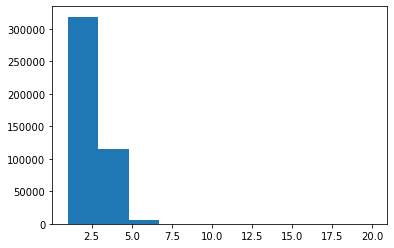

In [1459]:
# FAMILY MEMBERS
plt.hist(application_num['cnt_fam_members'])

<AxesSubplot:xlabel='cnt_fam_members'>

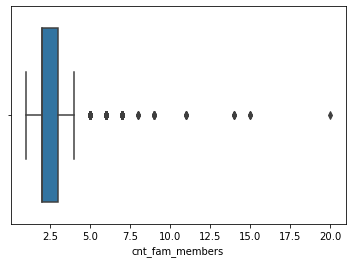

In [1460]:
sns.boxplot(x = application_num['cnt_fam_members'])

In [1461]:
application_num['cnt_fam_members'].value_counts()

2.0     233891
1.0      84492
3.0      77128
4.0      37356
5.0       5081
6.0        459
7.0        124
9.0          9
11.0         5
14.0         4
8.0          4
15.0         3
20.0         1
Name: cnt_fam_members, dtype: int64

In [1462]:
# AGE

import math

application_num['age'] = -application_num['days_birth'] / 365
application_num['age'] = application_num['age'].apply(lambda x: math.floor(x))

/var/folders/dj/n16zrnc50j79vq_pt7btwyg40000gn/T/ipykernel_44533/1899648218.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  application_num['age'] = -application_num['days_birth'] / 365
/var/folders/dj/n16zrnc50j79vq_pt7btwyg40000gn/T/ipykernel_44533/1899648218.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  application_num['age'] = application_num['age'].apply(lambda x: math.floor(x))


In [1463]:
application_num.drop('days_birth', axis = 1, inplace = True)

/Users/steib/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


<AxesSubplot:xlabel='age'>

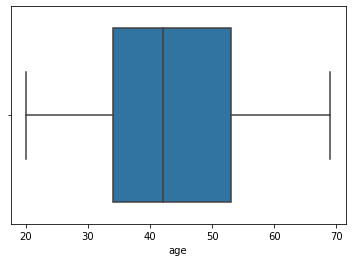

In [1464]:
sns.boxplot(x = application_num['age'])

In [1465]:
# EMPLOYEED

application_num['employed_since'] = -application_num['days_employed'] / 365
application_num['employed_since'] = application_num['employed_since'].apply(lambda x: math.floor(x))

/var/folders/dj/n16zrnc50j79vq_pt7btwyg40000gn/T/ipykernel_44533/1013940129.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  application_num['employed_since'] = -application_num['days_employed'] / 365
/var/folders/dj/n16zrnc50j79vq_pt7btwyg40000gn/T/ipykernel_44533/1013940129.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  application_num['employed_since'] = application_num['employed_since'].apply(lambda x: math.floor(x))


<AxesSubplot:xlabel='employed_since'>

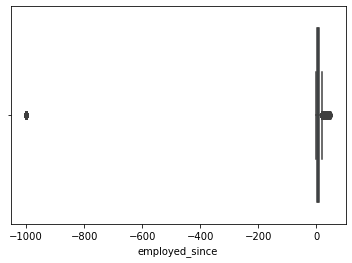

In [1466]:
sns.boxplot(x = application_num['employed_since'])

<AxesSubplot:xlabel='employed_since'>

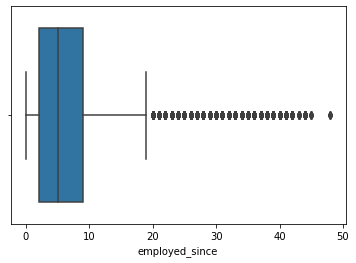

In [1467]:
# OUTLIER 
application_num = application_num.loc[application_num['employed_since'] >= 0]

sns.boxplot(x = application_num['employed_since'])

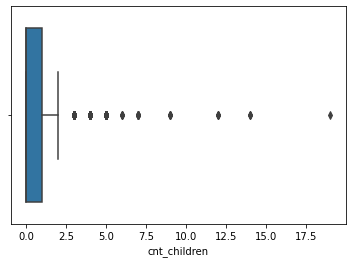

In [1468]:
# CHILDREN

sns.boxplot(x = application_num['cnt_children']) # There seems to be some unusally high number of children in the data set

# OUTLIER

application_num = application_num.loc[application_num['cnt_children'] < 15]

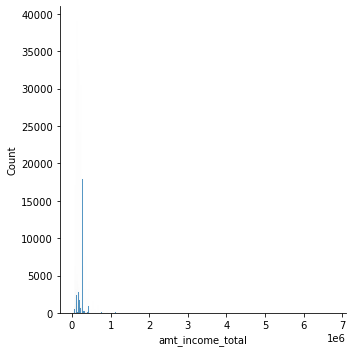

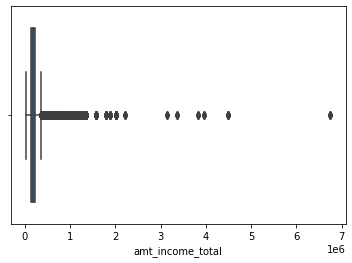

135000.0    38969
157500.0    33914
180000.0    33122
225000.0    30435
112500.0    29767
            ...  
163260.0        1
234900.0        1
936000.0        1
160425.0        1
143073.0        1
Name: amt_income_total, Length: 708, dtype: int64

In [1469]:
# INCOME

sns.displot(x = application_num['amt_income_total'])
plt.show()
sns.boxplot(x = application_num['amt_income_total'])
plt.show()

application_num['amt_income_total'].value_counts()

In [1470]:
application_num = application_num.loc[application_num['amt_income_total'] < 500000]

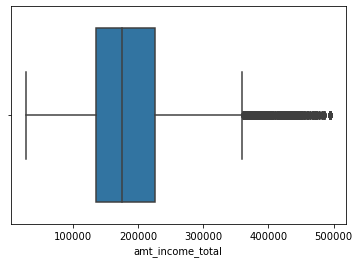

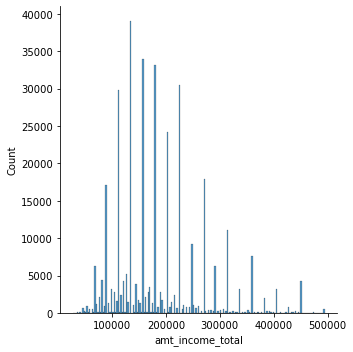

In [1471]:
sns.boxplot(x= application_num['amt_income_total'])
plt.show()
sns.displot(x = application_num['amt_income_total'])

In [1472]:
# CHECKING FOR APPROPRIATE BIN SIZE: 
pd.cut(x=application_num['amt_income_total'], bins = 6)

0         (417000.0, 495000.0]
1         (417000.0, 495000.0]
2         (105000.0, 183000.0]
3         (261000.0, 339000.0]
4         (261000.0, 339000.0]
                  ...         
438547    (105000.0, 183000.0]
438548    (105000.0, 183000.0]
438553     (26532.0, 105000.0]
438554     (26532.0, 105000.0]
438556    (105000.0, 183000.0]
Name: amt_income_total, Length: 358084, dtype: category
Categories (6, interval[float64, right]): [(26532.0, 105000.0] < (105000.0, 183000.0] < (183000.0, 261000.0] < (261000.0, 339000.0] < (339000.0, 417000.0] < (417000.0, 495000.0]]

In [1473]:
#Create customized bins: 
bins = [0,  100000, 200000, 300000, 400000, 500000]
labels = ['<=100k', '100k-200k', '200k-300k', '300k-400k', '400k+' ]

# Add column to categorical df
application_cat['income'] = pd.cut(x = application_num['amt_income_total'], bins = bins, labels = labels, include_lowest = True)

In [1474]:
# DROP REDUNDANT DATA
application_num.drop(['flag_mobil', 'flag_work_phone', 'flag_phone', 'flag_email', 'amt_income_total', 'days_employed'], axis = 1, inplace = True)

In [1475]:
print(application_num.shape)

(358084, 5)


In [1476]:
application_cat.isna().sum()

code_gender                0
flag_own_car               0
flag_own_realty            0
name_income_type           0
name_education_type        0
name_family_status         0
name_housing_type          0
occupation_type            0
id                         0
flag_mobil                 0
flag_work_phone            0
flag_phone                 0
flag_email                 0
income                 80473
dtype: int64

In [1477]:
application_cat.dropna(inplace=True)

#### Distribution and Transformation

In [1478]:
application_num.head()

,id,cnt_children,cnt_fam_members,age,employed_since
0,5008804,0,2.0,32,12
1,5008805,0,2.0,32,12
2,5008806,0,2.0,58,3
3,5008808,0,1.0,52,8
4,5008809,0,1.0,52,8


(array([1.72034e+05, 1.02431e+05, 4.47230e+04, 1.81890e+04, 8.99700e+03,
        6.52200e+03, 3.26800e+03, 1.42100e+03, 4.52000e+02, 4.70000e+01]),
 array([ 0. ,  4.8,  9.6, 14.4, 19.2, 24. , 28.8, 33.6, 38.4, 43.2, 48. ]),
 <BarContainer object of 10 artists>)

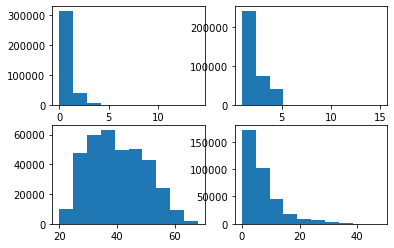

In [1479]:
# CHECKING DISTRIBUTION

plt.subplot(2,2,1)
plt.hist(application_num['cnt_children'])
plt.subplot(2,2,2)
plt.hist(application_num['cnt_fam_members'])
plt.subplot(2,2,3)
plt.hist(application_num['age'])
plt.subplot(2,2,4)
plt.hist(application_num['employed_since'])

In [1480]:
# CHECKING SUITABLE TRANSFORMATION
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler

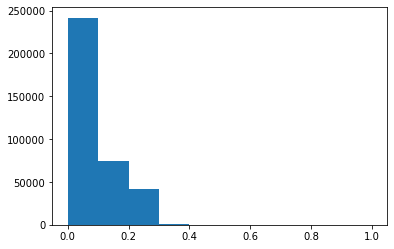

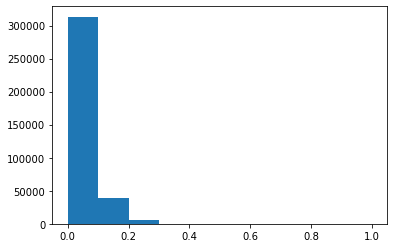

In [1481]:
# MinMaxSCALER for cnt children/family
fam_scaled = MinMaxScaler().fit_transform(application_num[['cnt_fam_members']])
plt.hist(fam_scaled)
plt.show()

children_scaled = MinMaxScaler().fit_transform(application_num[['cnt_children']])
plt.hist(children_scaled)
plt.show()

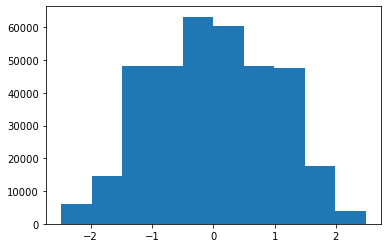

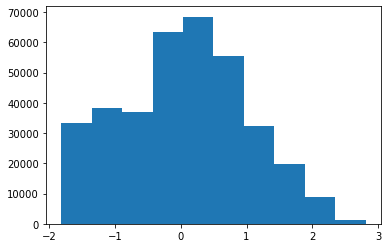

In [1482]:
# PowerTransformer BOXCOX for AGE and EMPLOYED SINCE

age_trans = trans.fit_transform(application_num[['age']])
plt.hist(age_trans)
plt.show()
employed_trans = trans.fit_transform(application_num[['employed_since']])
plt.hist(employed_trans)
plt.show()

In [1483]:
# Adding transformed data to df

application_num_transformed = application_num.copy()

application_num_transformed['age'] = age_trans
application_num_transformed['employed_since'] = employed_trans
application_num_transformed['cnt_children'] = children_scaled
application_num_transformed['cnt_fam_members'] = fam_scaled

### Feature Selection & Multicollinearity

In [1484]:
# COMBINING DF
print(application_num_transformed.shape)
print(application_cat.shape)
print(var_dep.shape)

print(application_num_transformed['id'].nunique())
print(application_cat['id'].nunique())
print(var_dep['id'].nunique())
print(credit_records['id'].nunique())
print(application_records['id'].nunique())

(358084, 5)
(358084, 14)
(45985, 4)
358053
358053
45985
45985
438510


In [1485]:
var_dep = var_dep.loc[:, ['id', 'default_flag']]
var_dep

,id,default_flag
0,5001711,0
2,5001712,0
4,5001713,0
5,5001714,0
6,5001715,0
...,...,...
94136,5150482,0
94138,5150483,0
94139,5150484,0
94141,5150485,0


In [1531]:
# MERGING WITH DEPENDENT VARIABLE
X_num_trans_y = pd.merge(application_num_transformed, var_dep, on = 'id')
X_cat_y = pd.merge(application_cat, var_dep, on ='id')

X_num_trans_y

,id,cnt_children,cnt_fam_members,age,employed_since,default_flag
0,5008804,0.0,0.071429,-0.814979,1.008426,0
1,5008805,0.0,0.071429,-0.814979,1.008426,0
2,5008806,0.0,0.071429,1.717329,-0.386807,0
3,5008808,0.0,0.000000,1.213284,0.553697,0
4,5008809,0.0,0.000000,1.213284,0.553697,0
...,...,...,...,...,...,...
29865,5149828,0.0,0.071429,0.762906,0.253266,1
29866,5149834,0.0,0.071429,-0.696179,-0.386807,0
29867,5149838,0.0,0.071429,-0.696179,-0.386807,0
29868,5150049,0.0,0.071429,0.946693,-1.127225,0


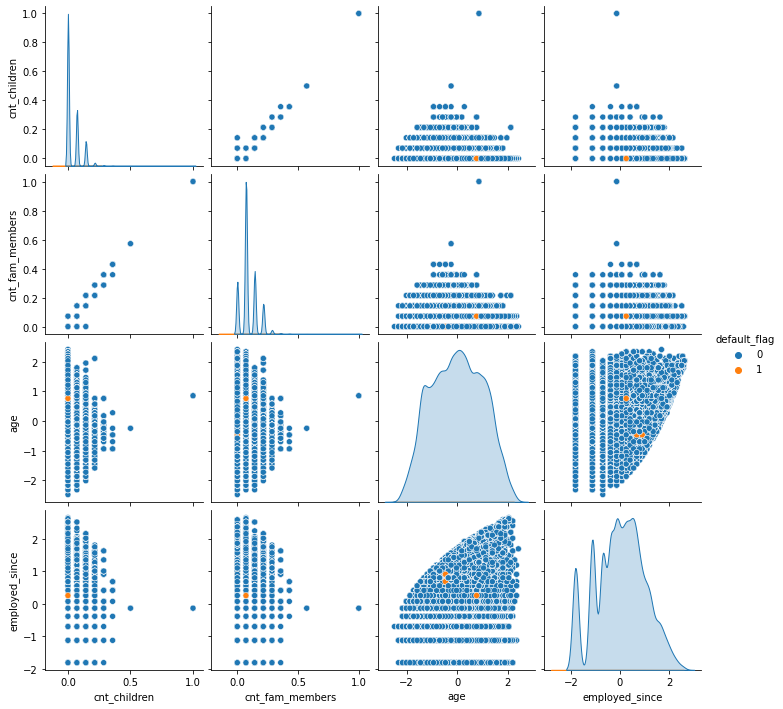

In [1534]:
plot_data = X_num_trans_y.drop('id', axis= 1)
sns.pairplot(plot_data, hue = 'default_flag')

#### Correlation Matrix

                 cnt_children  cnt_fam_members       age  employed_since
cnt_children         1.000000         0.900466 -0.238071       -0.033422
cnt_fam_members      0.900466         1.000000 -0.194086       -0.014117
age                 -0.238071        -0.194086  1.000000        0.300406
employed_since      -0.033422        -0.014117  0.300406        1.000000


<AxesSubplot:>

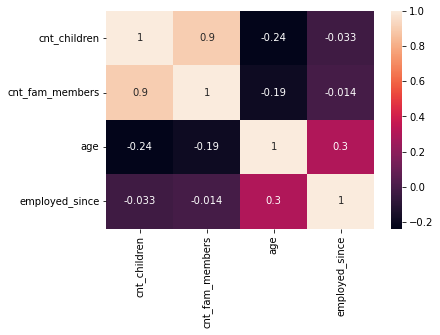

In [1550]:
# Checking with Correlation Matrix on the not merged datafr for numerical values: 
features = X_num_trans_y.drop(['id', 'default_flag'], axis= 1)
corr = features.corr()
print(corr)

sns.heatmap(corr, annot=True) # We can see a high correlation between the amount of children and family members

#### Variance Inflation Factor

In [1551]:
# Checking with VIR

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df):
    vif = pd.DataFrame()
    vif['features'] = df.columns
    vif['vif_value'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

calculate_vif(features)

,features,vif_value
0,cnt_children,4.850210
1,cnt_fam_members,4.718500
2,age,1.166159
3,employed_since,1.102008


In [1489]:
# Removing highly multicollinearity data: 
X_num_trans_y.drop('cnt_fam_members', axis = 1, inplace = True)

#### Chi-2 Test

In [1510]:
y = X_cat_y[['default_flag']]
X = X_cat_y.drop(['id', 'default_flag'], axis = 1)

<AxesSubplot:xlabel='default_flag', ylabel='income'>

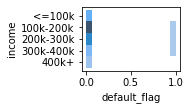

In [1527]:
plt.subplot(3,3,1)
sns.histplot(y = X['income'], x=y['default_flag'])

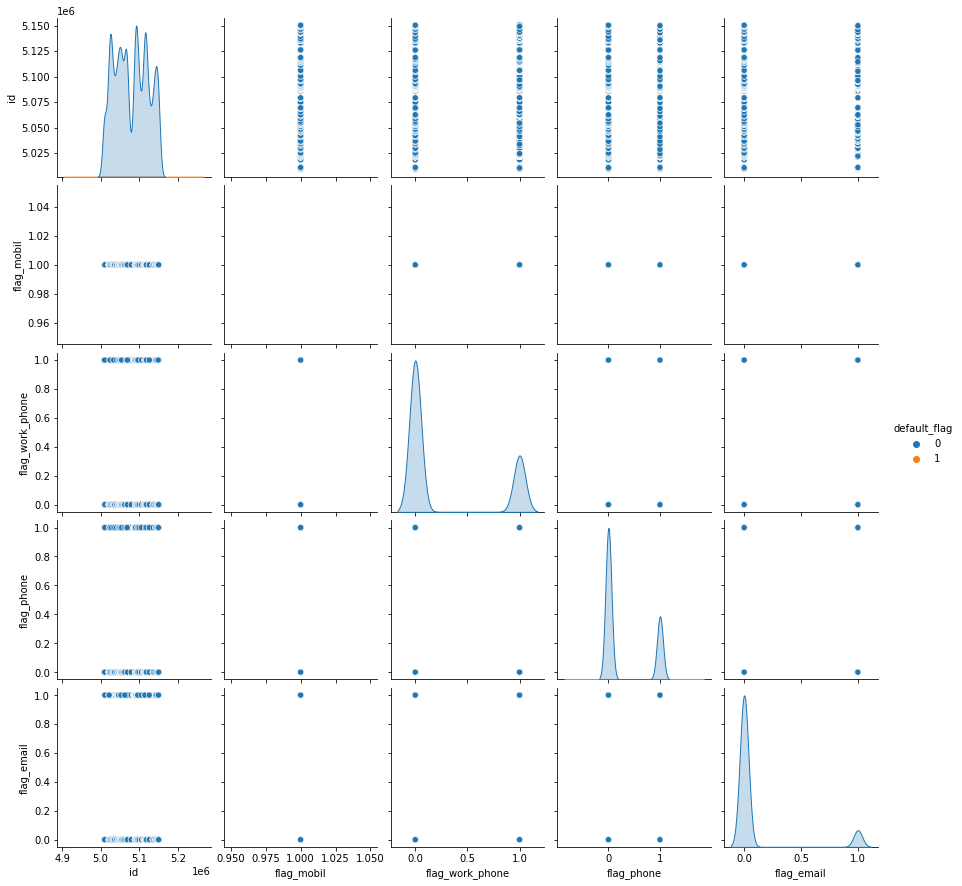

In [1555]:
sns.pairplot(X_cat_y, hue = 'default_flag')

##### Encoding Categorical 

In [1496]:
# ONE HOT ENCODER 
from sklearn.preprocessing import OneHotEncoder


enc = OneHotEncoder(drop='first')
X_encoded = enc.fit_transform(X).toarray()
X = pd.DataFrame(X_encoded, columns = enc.get_feature_names_out())


In [ ]:
# PERFORM CHI2

# X_y_split in order to avoid over fitting

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 22 )
X_train.head()
y_train.value_counts() # there is a huge class imbalance 


0    20906
1        3
Name: default_flag, dtype: int64

In [1498]:
# Dealing with imbalanced Data

from imblearn.over_sampling import SMOTE
sm = SMOTE(k_neighbors=2)
X_res, y_res = sm.fit_resample(X_train, y_train)

y_res.value_counts()

0    20906
1    20906
Name: default_flag, dtype: int64

In [1499]:
# Chi2 test

from sklearn.feature_selection import chi2

f_p_val = chi2(X_res, y_res)

print(f_p_val)

p_values = pd.Series(f_p_val[1])
p_values.index=X.columns
p_values.sort_values(ascending = True)

(array([  25.11862484,  159.09615235, 1562.88001857,   18.        ,
       2041.        ,   32.64079686,  941.        , 1408.8887644 ,
       4561.        , 1325.        , 1239.        ,  929.76286351,
       1149.64951655, 5625.        ,   58.79057611, 2052.        ,
       6018.        , 1637.        ,  550.        , 2384.        ]), array([5.39096567e-007, 1.78291876e-036, 0.00000000e+000, 2.20904970e-005,
       0.00000000e+000, 1.10863110e-008, 1.19986175e-206, 2.45972187e-308,
       0.00000000e+000, 4.17263799e-290, 2.03996658e-271, 3.32542808e-204,
       5.34637980e-252, 0.00000000e+000, 1.75379253e-014, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 1.25889679e-121, 0.00000000e+000]))


income_<=100k                               0.000000e+00
income_300k-400k                            0.000000e+00
flag_own_realty_Y                           0.000000e+00
income_200k-300k                            0.000000e+00
name_income_type_State servant              0.000000e+00
flag_email_1                                0.000000e+00
flag_work_phone_1                           0.000000e+00
name_family_status_Not Married              0.000000e+00
name_education_type_Secondary education    2.459722e-308
name_housing_type_Rented apartment         4.172638e-290
name_housing_type_With parents             2.039967e-271
occupation_type_Others                     5.346380e-252
name_education_type_Incomplete higher      1.199862e-206
occupation_type_Laborers                   3.325428e-204
income_400k+                               1.258897e-121
flag_own_car_Y                              1.782919e-36
flag_phone_1                                1.753793e-14
name_income_type_Working       

# NEXT STEPS: 

1) concat num, cat 

2) train test split

3) imbalance SMOTE

5) logistic regression

6) KNeigbhbors

7) Decision Tree

8) Random Forest

9) CVM




